In [13]:

import cv2
import torch
import torchvision
import sklearn.svm

#%pip install scikit-learn
#import sklearn

""" import torch
from torch import cuda
from torchvision import transforms, datasets, models
from pathlib import Path
from timeit import default_timer as timer
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter """

#from skimage.feature import hog
#from sklearn.svm import SVC
#from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
#from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

""" import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

#%pip install torchsummary 
from torchsummary import summary """


NameError: name 'platform' is not defined

In [3]:
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

BASE_PATH = Path('/project/volume/data/out/NIMH-CHEFS')
IMAGE_PATHS = list(BASE_PATH.rglob('*.jpg'))

TRAIN = 'train'
VAL = 'val'
TEST = 'test'

batch_size = 1



Train on gpu: False


In [4]:
# prepare data for feature extraction
feature_extraction_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

image_datasets = {
    x: datasets.ImageFolder(
        root=(BASE_PATH / x),
        transform=feature_extraction_transform
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=batch_size,
        shuffle=True, 
        num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = { x : len(image_datasets[x]) for x in [TRAIN, VAL, TEST] }
class_names = image_datasets[TRAIN].classes
n_classes = len(class_names)
n_images = 0
for x in [TRAIN, VAL, TEST]:
    print(f"[INFO] Number of images in {x} set ...{dataset_sizes[x]}")
    n_images += dataset_sizes[x]

print(f"[INFO] Number of images ...{n_images}")
print("[INFO] Number of classes: ", n_classes)
print("[INFO] Classes: ", image_datasets[TRAIN].classes)

[INFO] Number of images in train set ...320
[INFO] Number of images in val set ...106
[INFO] Number of images in test set ...107
[INFO] Number of images ...533
[INFO] Number of classes:  5
[INFO] Classes:  ['Afraid', 'Angry', 'Happy', 'Neutral', 'Sad']


In [5]:
# prepare vgg16 for feature extraction
conv_base = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
features = list(conv_base.classifier)[:-1]
conv_base.classifier = nn.Sequential(*features)
summary(conv_base, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|███████████████████████| 528M/528M [01:23<00:00, 6.61MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

In [7]:
def extract_features(dataloaders, batch_size, sample_count=batch_size): # phase: TRAIN / TEST / VAL

    features = torch.zeros(0, 4096)
    labels = torch.zeros(0, dtype=torch.long)

    for phase in tqdm([TRAIN, TEST, VAL]):
        dataset_size = dataset_sizes[phase]

        phase_features = torch.zeros(dataset_size, 4096)
        phase_labels = torch.zeros(dataset_size, dtype=torch.long)

        i = 0
        for inputs_batch, labels_batch in dataloaders[phase]:
            with torch.no_grad():
                features_batch = conv_base(inputs_batch)

            phase_features[i * batch_size : (i + 1) * batch_size] = features_batch
            phase_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
            i += 1
            if i * batch_size >= sample_count:
                break

        features = torch.cat((features, phase_features), dim=0)
        labels = torch.cat((labels, phase_labels), dim=0)

    return features, labels

In [8]:
features, labels = extract_features(dataloaders=dataloaders, batch_size=batch_size)

100%|████████████████████████████| 3/3 [00:05<00:00,  1.74s/it]


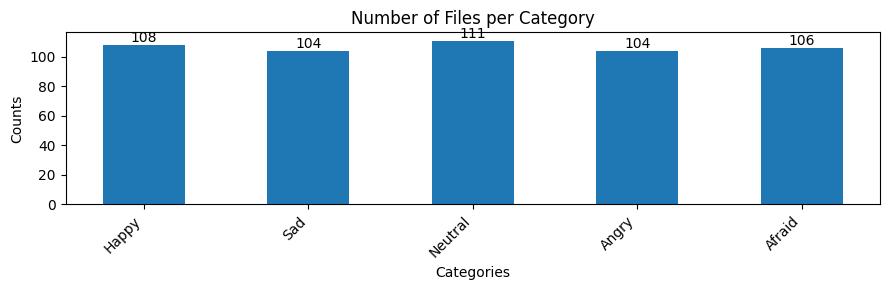

In [9]:
nbr_per_cat = Counter(Path(file).parent.name for file in IMAGE_PATHS)
categories = list(nbr_per_cat.keys())
counts = list(nbr_per_cat.values())

plt.figure(figsize=(9, 3))
bars = plt.bar(categories, counts, width=0.5)

plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Number of Files per Category')
plt.xticks(rotation=45, ha='right')

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), 
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

### SVM Init

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42)
